<a href="https://colab.research.google.com/github/ArleneYantingHuang/Natural-Language-Analysis-on-Delta-Airline/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [ ]:
!pip install python-decouple

  Created wheel for python-decouple: filename=python_decouple-3.3-cp36-none-any.whl size=9024 sha256=f01a65b4cc006ad293df9424b10de96f0db1db9b04188a64d97f6cd855819880
  Stored in directory: /root/.cache/pip/wheels/f4/9b/79/5eec9ea205382552b014e749cb8a2b4ce0d6836a6f4db5ac0c
Successfully built python-decouple


In [ ]:
!pip install webhoseio

  Created wheel for webhoseio: filename=webhoseio-0.5-cp36-none-any.whl size=2597 sha256=be8b62e11a73286f2a8b9f352ebc4977067b1bb014e8fdcade3da46926cb8346
  Stored in directory: /root/.cache/pip/wheels/89/7a/e2/069f55692658dad701f0086be60ca6c49a17f1f297490f2273
Successfully built webhoseio


In [ ]:
import webhoseio
import json

import datetime as dt
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. data crawling: Delta

In [ ]:
import webhoseio

webhoseio.config(token="b31b5fc7-e9f5-4b73-9f11-6d4cfb3393c0")
query_params = {
  "q": "Delta airline language:english site_type:news",
  "ts": "1593417041574",
  "sort": "crawled"
}

output = webhoseio.query("filterWebContent", query_params)

output = webhoseio.get_next()






In [ ]:
newsfeeds = []
for post in output['posts']:
    newsfeeds.append(post)
len(newsfeeds)

100

In [ ]:
output['requestsLeft']

261

In [ ]:
num_more_posts = output['moreResultsAvailable']
num_more_posts

6976

In [ ]:
count = 0
while count < num_more_posts:    
    output = webhoseio.get_next()
    for post in output['posts']:
        newsfeeds.append(post)
    count += 100
print(len(newsfeeds))

7076


In [ ]:
import json

with open("webhose_deltaairline.json", "w") as data_file:
    for feed in newsfeeds:
        line = json.dumps(feed)
        data_file.write(line)
        data_file.write("\n")

# 2. Deduplication



In [ ]:
json_data=open("webhose_deltaairline.json").readlines()

newsfeeds_read = []
for line in json_data:
    newsfeeds_read.append(json.loads(line))
print(len(newsfeeds_read))

7076


In [ ]:
title = []
unique = []
for i in newsfeeds_read:
    if i['title'] not in title:
        title.append(i['title'])
        unique.append(i)      
len(unique)


4182

In [ ]:
import json

with open("deltaunique.json", "w") as data_file:
    for feed in unique:
        line = json.dumps(feed)
        data_file.write(line)
        data_file.write("\n")

In [ ]:
# read in the data
import json
json_data = open("deltaunique.json").readlines()
delta = []
for line in json_data:
    delta.append(json.loads(line))

In [ ]:
feeds = []
i = 0
for feed in delta:
    feed['id'] = i
    i += 1
    feeds.append(feed)

In [ ]:
import webhoseio, os
from gensim.models import KeyedVectors
import json
from simhash import Simhash, SimhashIndex
import numpy as np

In [ ]:
# load the model
model_path = ''
def load_wordvec_model(modelName, modelFile, flagBin):
    print('Loading ' + modelName + ' model...')
    model = KeyedVectors.load_word2vec_format(model_path + modelFile, binary=flagBin)
    print('Finished loading ' + modelName + ' model...')
    return model
model_w2v_AP    = load_wordvec_model('Word2Vec Google News', 'GoogleNews-vectors-negative300.bin.gz', True)

In [ ]:
# define functions
# function checks whether the input words are present in the vocabulary for the model
def vocab_check(vectors, words):
    
    output = list()
    for word in words:
        if word in vectors.vocab:
            output.append(word.strip())
            
    return output

# function calculates similarity between two strings using a particular word vector model
def calc_similarity(input1, input2, vectors):
    s1words = set(vocab_check(vectors, input1.split()))
    s2words = set(vocab_check(vectors, input2.split()))
    
    output = vectors.n_similarity(s1words, s2words)
    return output

def cleanup(input):
    # remove English stopwords
    input = input.replace("'s", " ").replace("n’t", " not").replace("’ve", " have")
    input = re.sub(r'[^a-zA-Z0-9 ]', '', input)
    return input

In [ ]:
distance = 13

import logging
logging.getLogger('simhash').setLevel(logging.CRITICAL)
objs = [(str(feed['id']), Simhash(str(feed['title']))) for feed in feeds]
index = SimhashIndex(objs, k=distance)

remove = []
for i in range(1,len(delta)):
    SELECTED_INDEX = i
    feed_sel = feeds[SELECTED_INDEX]
    feed_hash = Simhash(str(feed_sel['title']))
    dup_indices = index.get_near_dups(feed_hash)
    dup_indices = [x for x in dup_indices if int(x) > SELECTED_INDEX]

    simHash_dup = len(dup_indices)

    count_dup = 0
    
    if simHash_dup >= 1:
        
        for dupi in dup_indices:
            try:
                score = calc_similarity(feed_sel['title'], feeds[int(dupi)]['title'], model_w2v_AP)
            except:
                score = 0
            if score > 0.5:
                count_dup += 1
                remove.append(int(dupi))

remove_unique = list(set(remove))
remove_unique.sort()

In [ ]:
#remove duplicated news
newsfeeds_dedup = delta
newsfeeds_dedup = [newsfeeds_dedup[i] for i in range(0, len(newsfeeds_dedup), 1) if i not in remove_unique]
len(newsfeeds_dedup)

In [ ]:
with open("Delta_deduplicated.json", "w") as data_file:
    for feed in newsfeeds_dedup:
        line = json.dumps(feed)
        data_file.write(line)
        data_file.write("\n")

#3. Model analsis

## 3.1 Entity analysis of the whole dataset

In [ ]:
import json

data = [json.loads(line) for line in open('/Delta_deduplicated.json','r',encoding='utf-8')]
len(data)

3212

In [ ]:
text = []
for d in data:
  text.append(d['text'])

len(text)

3212

In [ ]:
!pip install --upgrade "ibm-watson>=4.5.0"

Requirement already up-to-date: ibm-watson>=4.5.0 in /usr/local/lib/python3.6/dist-packages (4.5.0)


In [ ]:
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features, EntitiesOptions

#wen wang
authenticator = IAMAuthenticator('vssZkq19Dy2THiPFFsOnHs3a34UBZ60g1E7QhBasLISj')
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2019-07-12',
    authenticator=authenticator
)

#natural_language_understanding.set_service_url('https://api.us-south.natural-language-understanding.watson.cloud.ibm.com/instances/394998f1-3f85-411f-8a23-790603485ca5')
natural_language_understanding.set_service_url('https://api.us-south.natural-language-understanding.watson.cloud.ibm.com/instances/399ebbd3-c478-4e85-b20a-d9b20d738367')


In [ ]:
entities_location = []
for i in range(len(text)):
  try:
    response = natural_language_understanding.analyze(
        text = text[i],
        features=Features(entities=EntitiesOptions(sentiment=False,limit=100))).get_result()
    for dict in response['entities']:
      if dict['type'] in ['Location']:
        entities_location.append(dict['text'])
  except:
    print('Error in article '+data[i]['title'])
    print('*********************')
    continue

ERROR:root:unsupported text language: zh
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: unsupported text language: zh, Code: 400 , X-global-transaction-id: f00945c3876e645ee6c71b891137853d


Error in article 【中英對照】美國國務卿給共產中國的新冷戰檄文：龐畢歐在尼克森總統圖書館演說全文
*********************


ERROR:root:unsupported text language: sk
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: unsupported text language: sk, Code: 400 , X-global-transaction-id: bb17f7448e483028a0948d9d004807b7


Error in article Predbieha cena ropy vyvoj ekonomiky?
*********************


In [ ]:
len(entities_location),len(set(entities_location))

(23645, 2390)

In [ ]:
import pandas as pd
location = pd.DataFrame(entities_location)
location = location[0].value_counts().rename_axis('Location').reset_index()
location= location.rename(columns = {0:'counts'})
location.shape

(2390, 2)

In [ ]:
location

,Location,counts
0,U.S.,1040
1,New York,619
2,US,554
3,Southwest,503
4,Atlanta,462
5,London,399
6,United States,363
7,Europe,347
8,Los Angeles,346
9,Florida,327


In [ ]:
entities_company = []
for i in range(len(text)):
    try:
        response = natural_language_understanding.analyze(
            text = text[i],
            features=Features(entities=EntitiesOptions(sentiment=False,limit=100))).get_result()
        for dict in response['entities']:
            if dict['type'] in ['Company']:
                entities_company.append(dict['text'])
    except:
        print('Error in article '+data[i]['title'])
        print('*********************')
        continue

ERROR:root:unsupported text language: zh
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: unsupported text language: zh, Code: 400 , X-global-transaction-id: 5b88e2743f0991b156c1620990892403


Error in article 【中英對照】美國國務卿給共產中國的新冷戰檄文：龐畢歐在尼克森總統圖書館演說全文
*********************


ERROR:root:unsupported text language: sk
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: unsupported text language: sk, Code: 400 , X-global-transaction-id: 6a37fe858cb76a29234df27c6080dc0d


Error in article Predbieha cena ropy vyvoj ekonomiky?
*********************


In [ ]:
len(entities_company),len(set(entities_company))

(26507, 5974)

In [ ]:
company = pd.DataFrame(entities_company)
company = company[0].value_counts().rename_axis('Company').reset_index()
company = company.rename(columns = {0:'counts'})
company.shape

(5974, 2)

In [ ]:
company.head(10)

,Company,counts
0,Delta,1317
1,American Airlines,1034
2,United Airlines,814
3,Delta Air Lines,801
4,Southwest Airlines,391
5,JetBlue,376
6,Boeing,341
7,United,340
8,Reuters,280
9,Delta Airlines,278


In [ ]:
entities_organization = []
for i in range(len(text)):
    try:
        response = natural_language_understanding.analyze(
            text = text[i],
            features=Features(entities=EntitiesOptions(sentiment=False,limit=100))).get_result()
        for dict in response['entities']:
            if dict['type'] in ['Organization']:
                entities_organization.append(dict['text'])
    except:
        print('Error in article '+data[i]['title'])
        print('*********************')
        continue

ERROR:root:unsupported text language: zh
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: unsupported text language: zh, Code: 400 , X-global-transaction-id: 29c0dc787481b2430542a3eadc5fb1d8


Error in article 【中英對照】美國國務卿給共產中國的新冷戰檄文：龐畢歐在尼克森總統圖書館演說全文
*********************


ERROR:root:unsupported text language: sk
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: unsupported text language: sk, Code: 400 , X-global-transaction-id: 499116ffa357f00395ff54077c5a0806


Error in article Predbieha cena ropy vyvoj ekonomiky?
*********************


In [ ]:
len(entities_organization),len(set(entities_organization))

(9166, 3353)

In [ ]:
organization = pd.DataFrame(entities_organization)
organization = organization[0].value_counts().rename_axis('Organization').reset_index()
organization = organization.rename(columns = {0:'counts'})
organization.shape

(3353, 2)

In [ ]:
organization.head(10)

,Organization,counts
0,Congress,251
1,federal government,140
2,CDC,128
3,TSA,123
4,government,103
5,SEC,97
6,Senate,93
7,Trump administration,92
8,EU,89
9,International Air Transport Association,81


## 3.2 Topic Analysis


### 3.2.1 Get Topics

In [ ]:
! pip install iexfinance

     |████████████████████████████████| 51kB 1.4MB/s 


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import requests, json, re
import pandas as pd
import matplotlib
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from datetime import datetime
from iexfinance.stocks import get_historical_data

stopwords = set(stopwords.words('english'))
punctuation = set(string.punctuation) 

def text_cleanup(input_text):
    one = " ".join([i for i in input_text.lower().split() if i not in stopwords])
    two = "".join(re.sub(r'[^a-zA-Z ]', '', i) for i in one if i not in punctuation)
    three = [WordNetLemmatizer().lemmatize(i) for i in two.split()]
    return three

In [ ]:
import pandas as pd
df = pd.read_json ("Delta_deduplicated.json", lines = True)

In [ ]:
import nltk
nltk.download('wordnet')


In [ ]:
from gensim.models import ldamodel
from gensim.corpora.dictionary import Dictionary
import os

In [ ]:
num_topics=5
titles = df[['text']].applymap(text_cleanup)['text']
dictionary = Dictionary(titles)
dictionary.filter_extremes(no_below=10, no_above=0.8)
corpora = [dictionary.doc2bow(doc) for doc in titles]

In [ ]:
# Running and Trainign LDA model on the document term matrix.
lda_model = ldamodel.LdaModel(corpora, num_topics=num_topics, id2word = dictionary, passes=50, random_state = 5430)

In [ ]:
vocab_list=list(dictionary.items())
for i in range(num_topics):
    print('The following words are the keywords of cluster %d'%i)
    for keyword,weight in lda_model.get_topic_terms(i):
        print(vocab_list[keyword][-1])
    print('************')

In [ ]:
keyword_dict={}
for i in range(num_topics):
    keyword_str=''
    for keyword,weight in lda_model.get_topic_terms(i):
        keyword_str+=vocab_list[keyword][-1]+','
    keyword_dict[i]=keyword_str.strip(',')

In [ ]:
def get_topic(ldamodel=lda_model, corpus=corpora, texts = df['text']):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    #contents = pd.Series(texts)
    #sent_topics_df = sent_topics_df.merge(text.to_frame(), left_index=True, right_index=True)
    #sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



In [ ]:
topicresult = get_topic(ldamodel=lda_model, corpus=corpora, texts = df['text'])

In [ ]:
result = df[['title','text','published']]
result['topic'] = topicresult['Dominant_Topic']
result['perc_contribution'] = topicresult['Perc_Contribution']
result['Topic_keywords'] = topicresult['Topic_Keywords']
result['published'] = pd.to_datetime(result['published'])
result['month']=result.published.dt.month
result['day']=result.published.dt.day

### 3.2.2 Topics analysis based on stock price trends
DAL1.csv is a csv file containing Delta's stock price which we downloaded from Yahoo.

In [ ]:
stockprice = pd.read_csv('DAL1.csv')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#### topic0 CreditCard

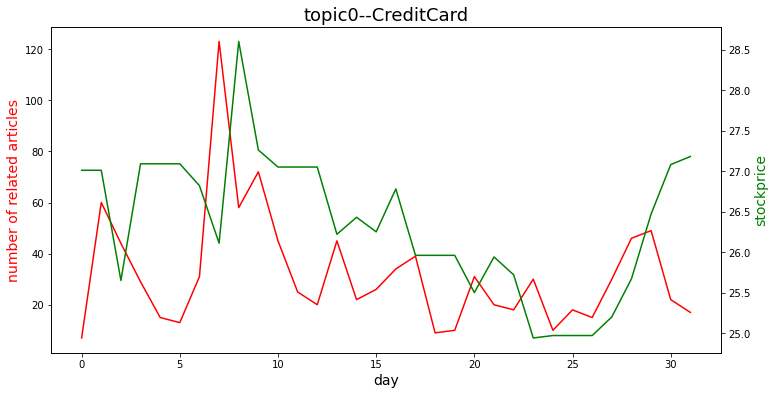

In [ ]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(result[result['topic']==0][['title','month','day']].groupby(['month','day']).count().values, color = 'red')
ax.set_xlabel("day",fontsize=14)
ax.set_ylabel("number of related articles",color="red",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(stockprice['Close'],color="green")
ax2.set_ylabel("stockprice",color="green",fontsize=14)
plt.title('topic0--CreditCard', fontsize=18)
plt.show()


In [ ]:
# correlation efficient
a = result[result['topic']==0][['title','month','day']].groupby(['month','day']).count().values.tolist()
lst = []
for i in a:
  for j in i:
    lst.append(j)

np.corrcoef(lst, stockprice['Close'])[0,1]

0.18073382469089014

#### topic1 Masks

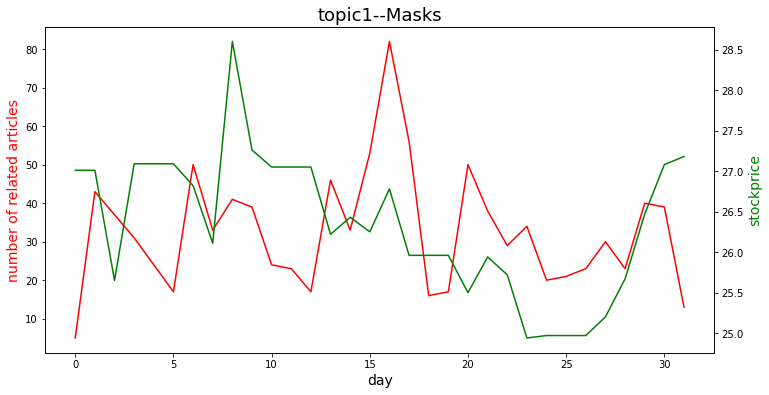

In [ ]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(result[result['topic']==1][['title','month','day']].groupby(['month','day']).count().values, color = 'red')
ax.set_xlabel("day",fontsize=14)
ax.set_ylabel("number of related articles",color="red",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(stockprice['Close'],color="green")
ax2.set_ylabel("stockprice",color="green",fontsize=14)
plt.title('topic1--Masks', fontsize = 18)
plt.show()

In [ ]:
# correlation efficient
a = result[result['topic']==1][['title','month','day']].groupby(['month','day']).count().values.tolist()
lst = []
for i in a:
  for j in i:
    lst.append(j)

np.corrcoef(lst, stockprice['Close'])[0,1]

0.060723082028988816

#### topic2--Covid19

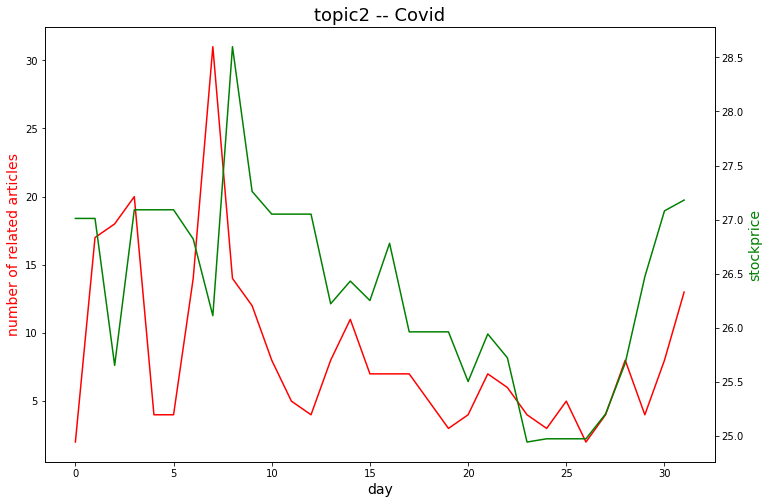

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(result[result['topic']==2][['title','month','day']].groupby(['month','day']).count().values, color = 'red')
ax.set_xlabel("day",fontsize=14)
ax.set_ylabel("number of related articles",color="red",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(stockprice['Close'],color="green")
ax2.set_ylabel("stockprice",color="green",fontsize=14)
plt.title('topic2 -- Covid', fontsize = 18)
plt.show()

In [ ]:
# correlation efficient
a = result[result['topic']==2][['title','month','day']].groupby(['month','day']).count().values.tolist()
lst = []
for i in a:
  for j in i:
    lst.append(j)

np.corrcoef(lst, stockprice['Close'])[0,1]

0.2896769718139418

#### topic3 Stock Market

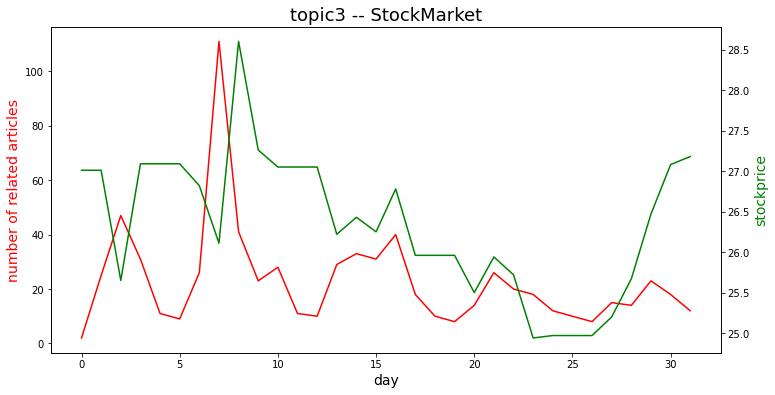

In [ ]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(result[result['topic']==3][['title','month','day']].groupby(['month','day']).count().values, color = 'red')
ax.set_xlabel("day",fontsize=14)
ax.set_ylabel("number of related articles",color="red",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(stockprice['Close'],color="green")
ax2.set_ylabel("stockprice",color="green",fontsize=14)
plt.title('topic3 -- StockMarket', fontsize = 18)
plt.show()

In [ ]:
# correlation efficient
a = result[result['topic']==3][['title','month','day']].groupby(['month','day']).count().values.tolist()
lst = []
for i in a:
  for j in i:
    lst.append(j)

np.corrcoef(lst, stockprice['Close'])[0,1]

0.10584017335094793

#### topic4 International Flight

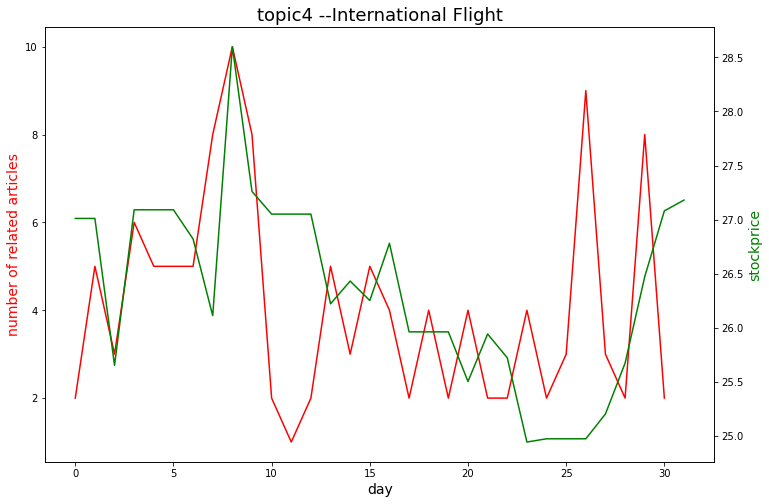

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(result[result['topic']==4][['title','month','day']].groupby(['month','day']).count().values, color = 'red')
ax.set_xlabel("day",fontsize=14)
ax.set_ylabel("number of related articles",color="red",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(stockprice['Close'],color="green")
ax2.set_ylabel("stockprice",color="green",fontsize=14)
plt.title('topic4 --International Flight', fontsize = 18)
plt.show()

In [ ]:
# correlation efficient
a = result[result['topic']==4][['title','month','day']].groupby(['month','day']).count().values.tolist()
lst = []
for i in a:
  for j in i:
    lst.append(j)
lst.insert(4,0)
np.corrcoef(lst, stockprice['Close'])[0,1]

0.3142432351657263

#### overall

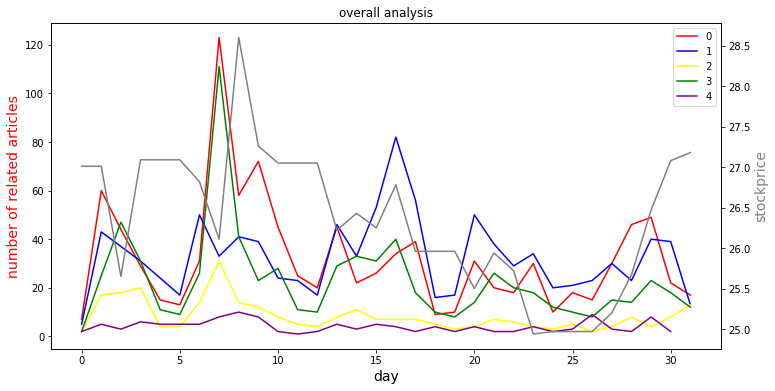

In [ ]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(result[result['topic']==0][['title','month','day']].groupby(['month','day']).count().values, color = 'red')
ax.plot(result[result['topic']==1][['title','month','day']].groupby(['month','day']).count().values, color = 'blue')
ax.plot(result[result['topic']==2][['title','month','day']].groupby(['month','day']).count().values, color = 'yellow')
ax.plot(result[result['topic']==3][['title','month','day']].groupby(['month','day']).count().values, color = 'green')
ax.plot(result[result['topic']==4][['title','month','day']].groupby(['month','day']).count().values, color = 'purple')
ax.legend(['0','1','2','3','4'])
ax.set_xlabel("day",fontsize=14)
ax.set_ylabel("number of related articles",color="red",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(stockprice['Close'],color="grey")
ax2.set_ylabel("stockprice",color="grey",fontsize=14)
plt.title('overall analysis')
plt.show()

### 3.2.3 Topic-stock price diff

In [ ]:
diff = stockprice['Close'].diff()
zero = [0]*32

In [ ]:
topic = ['CreditCard', 'Masks', 'Covid19', 'Stock Market', 'International Flight']

In [ ]:
coef_list3 = []
# correlation efficient
for topicn in range(5):
  a = result[result['topic']==topicn][['month','day','title']].groupby(['month','day']).count().values.tolist()
  lst = []
  for i in a:
    for j in i:
      lst.append(j)
  if topicn == 4:
    lst.insert(4,0)
  coe = np.corrcoef(lst[1:], diff[1:])[0,1]
  print(str(topicn),':', coe)
  coef_list3.append(coe)

0 : -0.15912206323294542
1 : -0.03177186624485185
2 : -0.017753448520446958
3 : -0.07521424112167405
4 : 0.20170207776395616


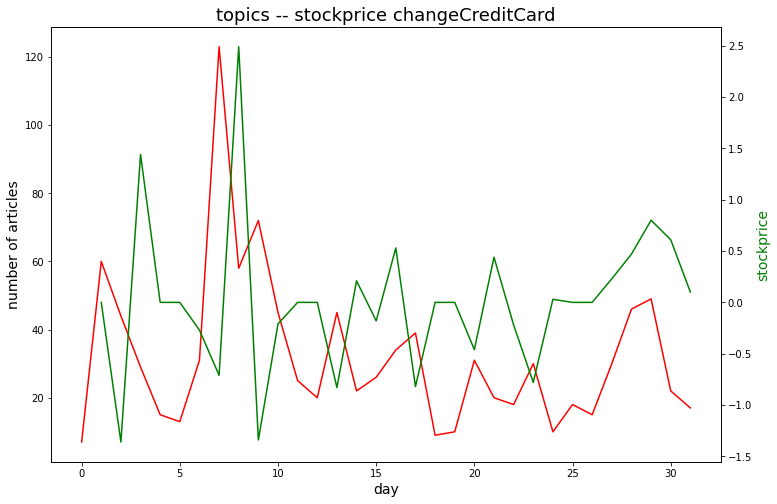

correlation:-0.15912206323294542


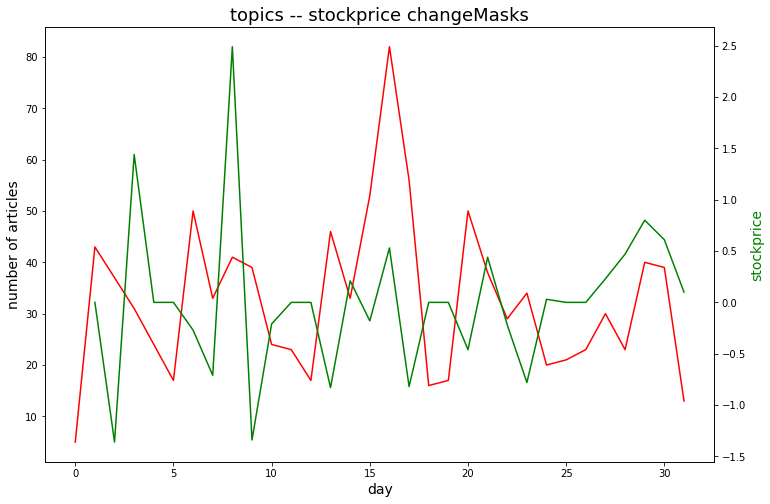

correlation:-0.03177186624485185


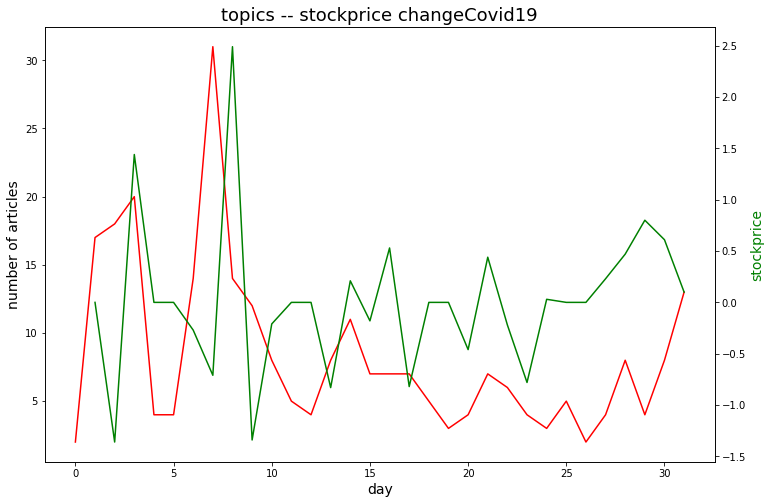

correlation:-0.017753448520446958


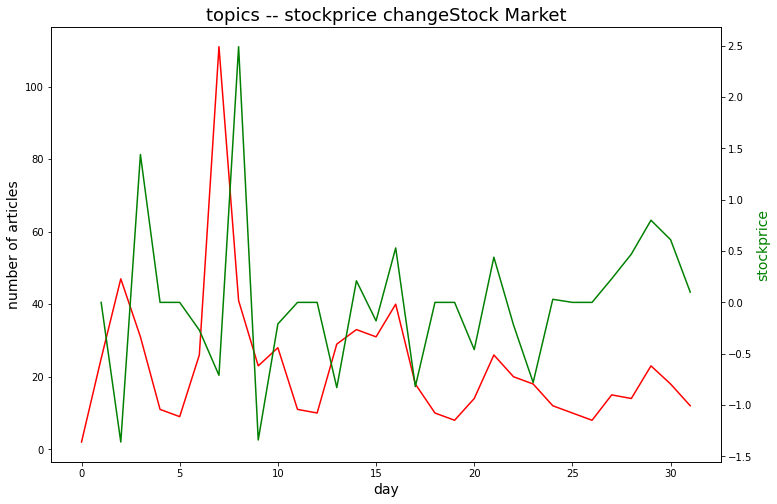

correlation:-0.07521424112167405


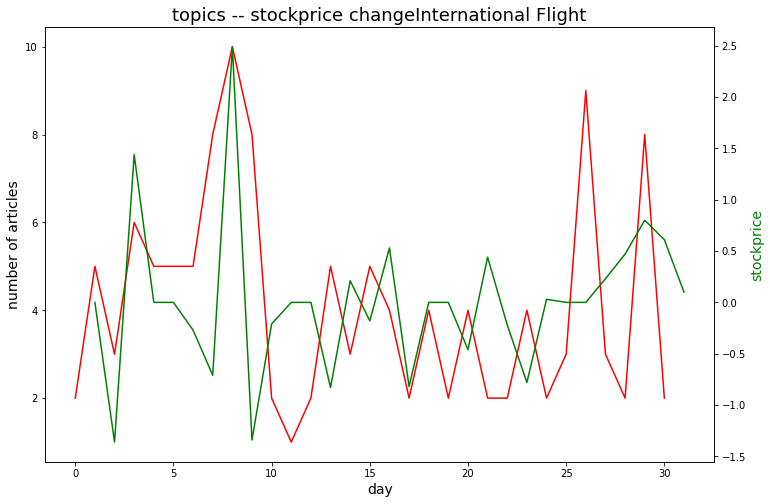

correlation:0.20170207776395616


In [ ]:
for i in range(5):
  fig,ax = plt.subplots(figsize=(12,8))
  ax.plot(result[result['topic']==i][['month','day','title']].groupby(['month','day']).count().values,color='red')
  ax.set_xlabel("day",fontsize=14)
  ax.set_ylabel("number of articles",fontsize=14)
  ax2=ax.twinx()

  # make a plot with different y-axis using second axis object
  ax2.plot(diff,color="green")
  ax2.set_ylabel("stockprice",color="green",fontsize=14)
  plt.title('topics -- stockprice change'+ topic[i], fontsize = 18)
  plt.show()
  print("correlation:" + str(coef_list3[i]))

## 3.3 Sentiment Analysis


### 3.3.1 Get Sentiment Score

In [ ]:
import string,re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from nltk.corpus import stopwords,wordnet
from nltk import tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag,FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
import nltk
nltk.download('vader_lexicon')
stopword_list=stopwords.words('english')
stopword_list+=['1','2','3','4','5','6','7','8','9','perhaps','u','—','also','almost','already','nearly','...','still']
tokenizer=tokenize.TweetTokenizer()
wnl=WordNetLemmatizer()
sia=SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
score_list=[]
for article in df.text:
    sentences=tokenize.sent_tokenize(article)
    mean=0
    for sentence in sentences:
        pol_score=sia.polarity_scores(sentence)['compound']
        mean+=pol_score
    mean=mean/len(sentences)
    score_list.append(mean)


In [ ]:
result['sentiment'] = score_list

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
result.to_csv('result.csv')

### 3.3.2 Sentiment Analysis Based on Stock Price Trends

#### sentiment & stock price

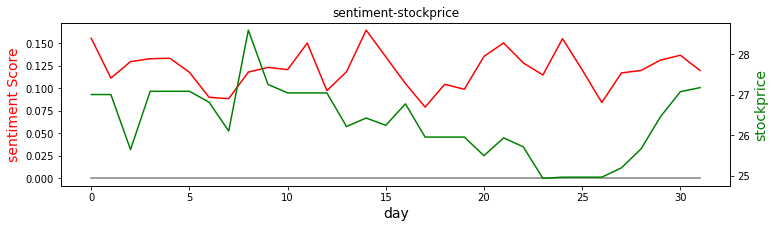

In [ ]:
fig,ax = plt.subplots(figsize=(12,3))
ax.plot(result[['sentiment','month','day']].groupby(['month','day']).mean().values, color = 'red')
ax.plot(zero, color = 'grey')
ax.set_xlabel("day",fontsize=14)
ax.set_ylabel("sentiment Score",color="red",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(stockprice['Close'],color="green")
ax2.set_ylabel("stockprice",color="green",fontsize=14)
plt.title('sentiment-stockprice')
plt.show()

In [ ]:
# correlation efficient
a = result[['sentiment','month','day']].groupby(['month','day']).mean().values.tolist()
lst = []
for i in a:
  for j in i:
    lst.append(j)

np.corrcoef(lst, stockprice['Close'])[0,1]

0.08171908155989728

#### sentiment & price diff

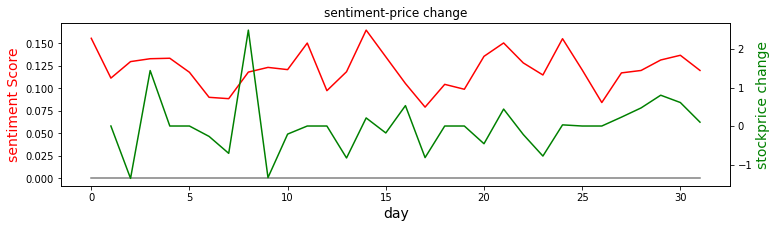

In [ ]:
fig,ax = plt.subplots(figsize=(12,3))
ax.plot(result[['sentiment','month','day']].groupby(['month','day']).mean().values, color = 'red')
ax.plot(zero, color = 'grey')
ax.set_xlabel("day",fontsize=14)
ax.set_ylabel("sentiment Score",color="red",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(diff,color="green")
#ax2.plot(zero,color="grey")
ax2.set_ylabel("stockprice change",color="green",fontsize=14)
plt.title('sentiment-price change')
plt.show()

In [ ]:
# correlation efficient
a = result[['sentiment','month','day']].groupby(['month','day']).mean().values.tolist()
lst = []
for i in a:
  for j in i:
    lst.append(j)
    
np.corrcoef(lst[1:], diff[1:])[0,1]

0.19103388748922068

#### sentiment.ma2 & price

In [ ]:
a = result[['sentiment','month','day']].groupby(['month','day']).mean().values.tolist()
lst = []
for i in a:
  for j in i:
    lst.append(j)

In [ ]:
sentiment = pd.DataFrame()
sentiment['sentimentscore'] = lst

In [ ]:
sentiment_ma2 = sentiment.sentimentscore.rolling(window = 2).mean()

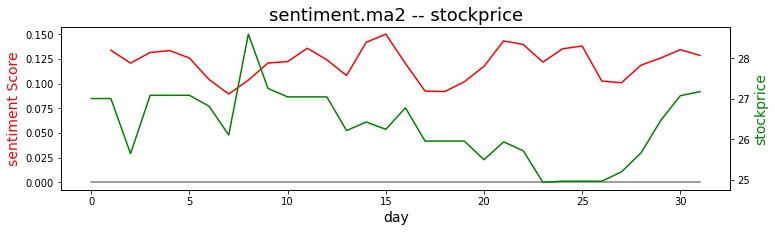

In [ ]:
fig,ax = plt.subplots(figsize=(12,3))
ax.plot(sentiment_ma2, color = 'red')
ax.plot(zero, color = 'grey')
ax.set_xlabel("day",fontsize=14)
ax.set_ylabel("sentiment Score",color="red",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(stockprice['Close'],color="green")
ax2.set_ylabel("stockprice",color="green",fontsize=14)
plt.title('sentiment.ma2 -- stockprice', fontsize = 18)
plt.show()

In [ ]:
np.corrcoef(sentiment_ma2[1:],stockprice['Close'][1:])[0,1]

0.08727300051084955

#### sentiment.ma2 & price diff

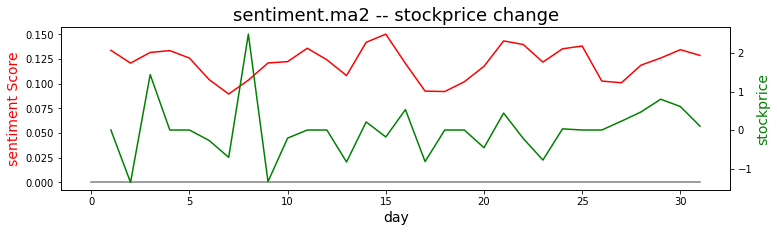

In [ ]:
fig,ax = plt.subplots(figsize=(12,3))
ax.plot(sentiment_ma2, color = 'red')
ax.plot(zero, color = 'grey')
ax.set_xlabel("day",fontsize=14)
ax.set_ylabel("sentiment Score",color="red",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(diff,color="green")
ax2.set_ylabel("stockprice",color="green",fontsize=14)
plt.title('sentiment.ma2 -- stockprice change', fontsize = 18)
plt.show()

In [ ]:
np.corrcoef(sentiment_ma2[1:],diff[1:])[0,1]

0.1251340573825497

#### sentiment.ma3 & price

In [ ]:
sentiment_ma3 = sentiment.sentimentscore.rolling(window = 3).mean()

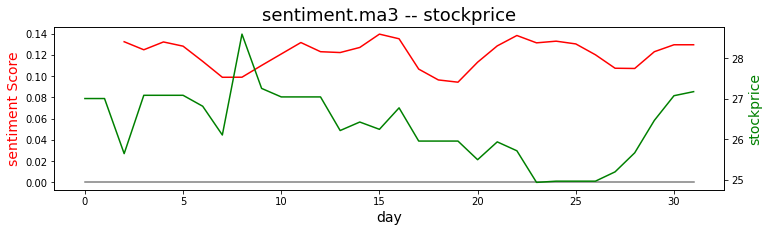

In [ ]:
fig,ax = plt.subplots(figsize=(12,3))
ax.plot(sentiment_ma3, color = 'red')
ax.plot(zero, color = 'grey')
ax.set_xlabel("day",fontsize=14)
ax.set_ylabel("sentiment Score",color="red",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(stockprice['Close'],color="green")
ax2.set_ylabel("stockprice",color="green",fontsize=14)
plt.title('sentiment.ma3 -- stockprice', fontsize = 18)
plt.show()

In [ ]:
np.corrcoef(sentiment_ma3[2:],stockprice['Close'][2:])[0,1]

-0.06488692557876324

#### sentiment ma3 & price diff

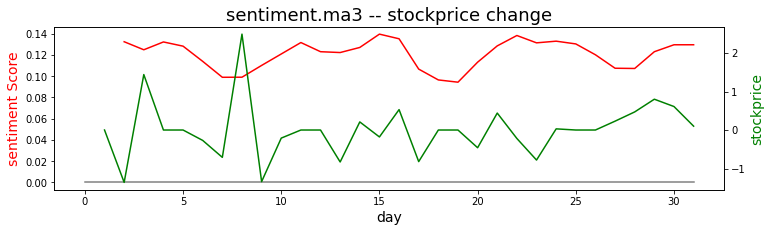

In [ ]:
fig,ax = plt.subplots(figsize=(12,3))
ax.plot(sentiment_ma3, color = 'red')
ax.plot(zero, color = 'grey')
ax.set_xlabel("day",fontsize=14)
ax.set_ylabel("sentiment Score",color="red",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(diff,color="green")
ax2.set_ylabel("stockprice",color="green",fontsize=14)
plt.title('sentiment.ma3 -- stockprice change', fontsize = 18)
plt.show()

In [ ]:
np.corrcoef(sentiment_ma3[2:],diff[2:])[0,1]

-0.0796372715426823

## 3.4 Topic- Sentiment analysis based on stock price

---



#### Topic Sentiment -- Stock Price

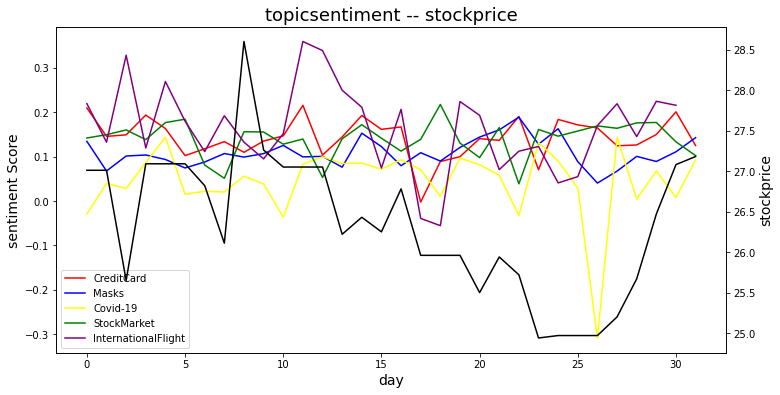

In [ ]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(result[result['topic']==0][['month','day','sentiment']].groupby(['month','day']).mean().values,color='red')
ax.plot(result[result['topic']==1][['month','day','sentiment']].groupby(['month','day']).mean().values,color='blue')
ax.plot(result[result['topic']==2][['month','day','sentiment']].groupby(['month','day']).mean().values,color='yellow')
ax.plot(result[result['topic']==3][['month','day','sentiment']].groupby(['month','day']).mean().values,color='green')
ax.plot(result[result['topic']==4][['month','day','sentiment']].groupby(['month','day']).mean().values,color='purple')
ax.legend(['CreditCard','Masks','Covid-19','StockMarket','InternationalFlight'])
ax.set_xlabel("day",fontsize=14)
ax.set_ylabel("sentiment Score",fontsize=14)
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(stockprice['Close'],color="black")
ax2.set_ylabel("stockprice",color="black",fontsize=14)
plt.title('topicsentiment -- stockprice', fontsize = 18)
plt.show()

In [ ]:
coef_list = []
# correlation efficient
for topicn in range(5):
  a = result[result['topic']==topicn][['month','day','sentiment']].groupby(['month','day']).mean().values.tolist()
  lst = []
  for i in a:
    for j in i:
      lst.append(j)
  if topicn == 4:
    lst.insert(4,0)
  coe = np.corrcoef(lst, stockprice['Close'])[0,1]
  print(str(topicn),':', coe)
  coef_list.append(coe)


0 : 0.09693761098323664
1 : -0.09767445310826615
2 : 0.15245756548335793
3 : -0.09818635377446872
4 : 0.19778386667459172


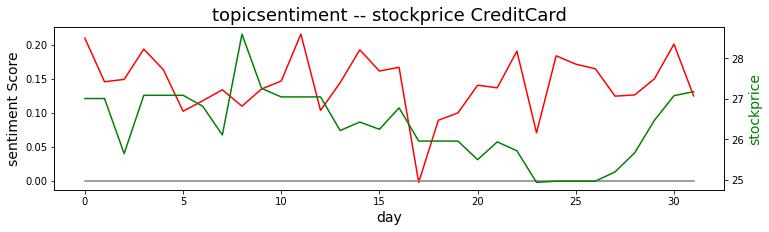

correlation:0.09693761098323664


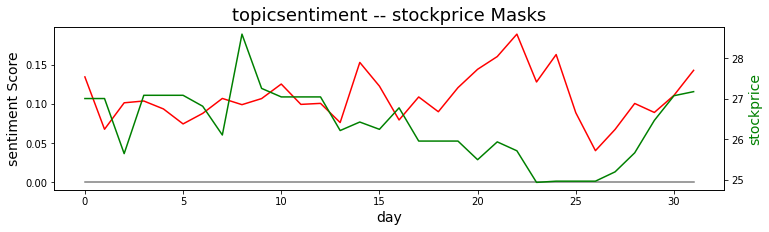

correlation:-0.09767445310826615


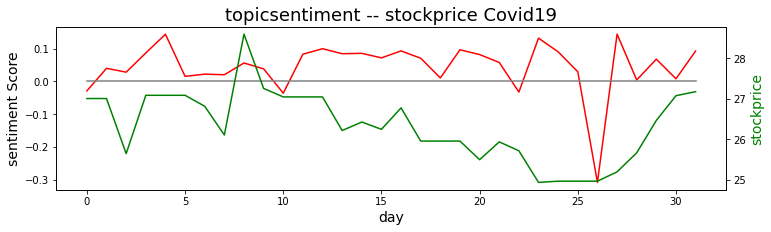

correlation:0.15245756548335793


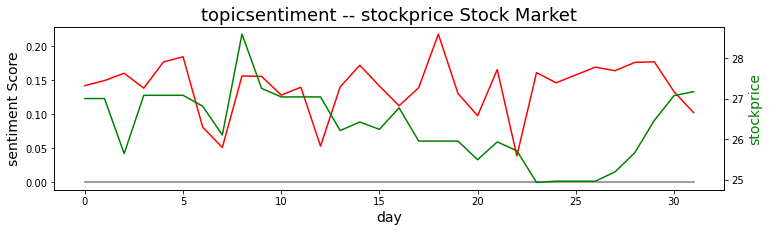

correlation:-0.09818635377446872


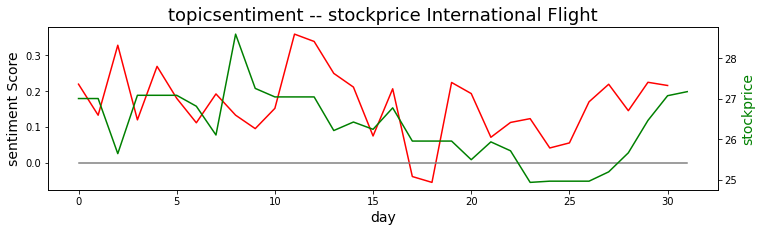

correlation:0.19778386667459172


In [ ]:
for i in range(5):
  fig,ax = plt.subplots(figsize=(12,3))
  ax.plot(result[result['topic']==i][['month','day','sentiment']].groupby(['month','day']).mean().values,color='red')
  ax.plot(zero, color = 'grey')
  ax.set_xlabel("day",fontsize=14)
  ax.set_ylabel("sentiment Score",fontsize=14)
  ax2=ax.twinx()

  # make a plot with different y-axis using second axis object
  ax2.plot(stockprice['Close'],color="green")
  ax2.set_ylabel("stockprice",color="green",fontsize=14)
  plt.title('topicsentiment -- stockprice '+ topic[i], fontsize = 18)
  plt.show()
  print("correlation:" + str(coef_list[i]))

### Topic Sentiment -- Stock Price Change

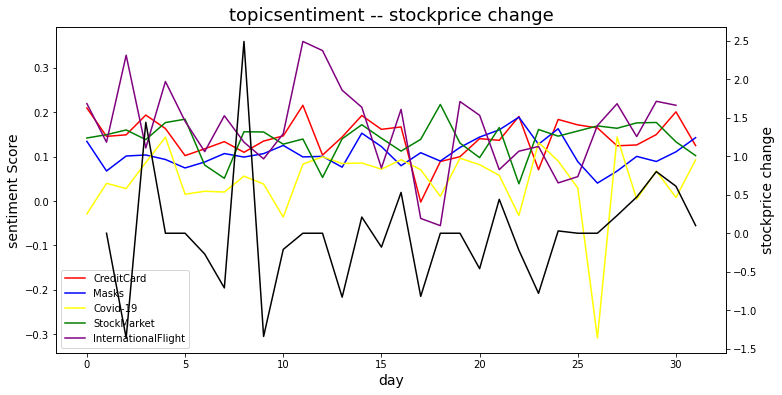

In [ ]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(result[result['topic']==0][['month','day','sentiment']].groupby(['month','day']).mean().values,color='red')
ax.plot(result[result['topic']==1][['month','day','sentiment']].groupby(['month','day']).mean().values,color='blue')
ax.plot(result[result['topic']==2][['month','day','sentiment']].groupby(['month','day']).mean().values,color='yellow')
ax.plot(result[result['topic']==3][['month','day','sentiment']].groupby(['month','day']).mean().values,color='green')
ax.plot(result[result['topic']==4][['month','day','sentiment']].groupby(['month','day']).mean().values,color='purple')
ax.legend(['CreditCard','Masks','Covid-19','StockMarket','InternationalFlight'])
ax.set_xlabel("day",fontsize=14)
ax.set_ylabel("sentiment Score",fontsize=14)
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(diff,color="black")
ax2.set_ylabel("stockprice change",color="black",fontsize=14)
plt.title('topicsentiment -- stockprice change', fontsize = 18)
plt.show()

In [ ]:
coef_list2 = []
# correlation efficient
for topicn in range(5):
  a = result[result['topic']==topicn][['month','day','sentiment']].groupby(['month','day']).mean().values.tolist()
  lst = []
  for i in a:
    for j in i:
      lst.append(j)
  if topicn == 4:
    lst.insert(4,0)
  coe = np.corrcoef(lst[1:], diff[1:])[0,1]
  print(str(topicn),':', coe)
  coef_list2.append(coe)

0 : 0.22109951019170213
1 : -0.06440349550268046
2 : 0.04384764638774669
3 : 0.15804476548796792
4 : -0.10860746533784175


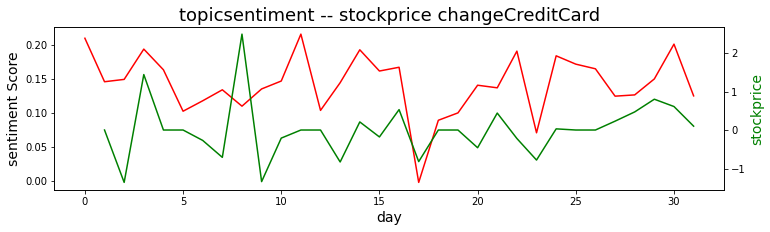

correlation:0.22109951019170213


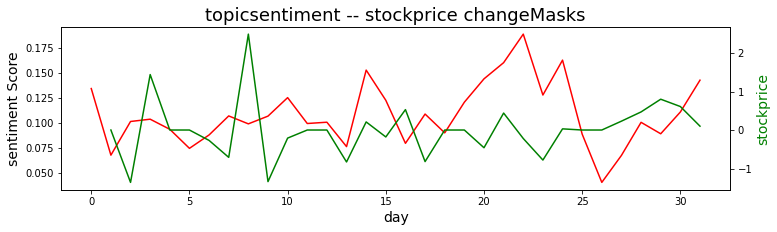

correlation:-0.06440349550268046


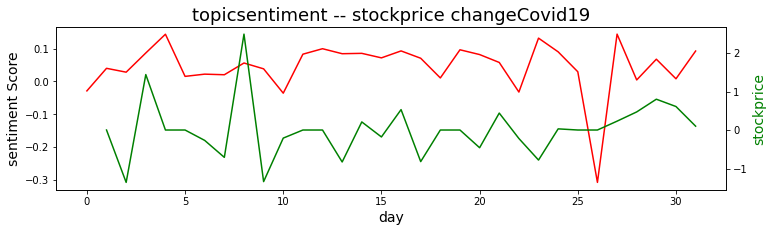

correlation:0.04384764638774669


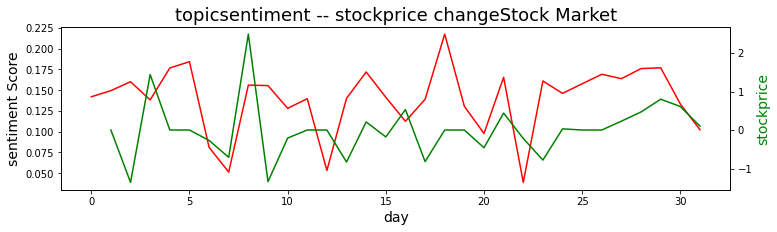

correlation:0.15804476548796792


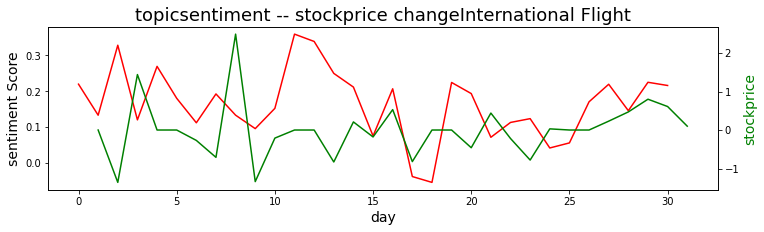

correlation:-0.10860746533784175


In [ ]:
for i in range(5):
  fig,ax = plt.subplots(figsize=(12,3))
  ax.plot(result[result['topic']==i][['month','day','sentiment']].groupby(['month','day']).mean().values,color='red')
  ax.set_xlabel("day",fontsize=14)
  ax.set_ylabel("sentiment Score",fontsize=14)
  ax2=ax.twinx()

  # make a plot with different y-axis using second axis object
  ax2.plot(diff,color="green")
  ax2.set_ylabel("stockprice",color="green",fontsize=14)
  plt.title('topicsentiment -- stockprice change'+ topic[i], fontsize = 18)
  plt.show()
  print("correlation:" + str(coef_list2[i]))